# Imports

In [2]:
import pandas as pd 
import json
import os
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import punkt
import nltk
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, f1_score
from sklearn.linear_model import LogisticRegression
import string
from nltk.probability import FreqDist
import seaborn as sns
pd.options.display.max_rows = 999
pd.options.display.max_columns = 30
import lexnlp as lnlp
import src
import importlib
import unidecode as unidecode
importlib.reload(src)
%matplotlib inline


# Data Formating

## Importing SCDB file

In [15]:
df = pd.read_csv('../data/SCDB_2020_01_caseCentered_Citation.csv',encoding='cp1252' ) #importing data
df.head() #checking the DataFrame

,caseId,docketId,caseIssuesId,voteId,dateDecision,decisionType,usCite,sctCite,ledCite,lexisCite,term,naturalCourt,chief,docket,caseName,...,voteUnclear,issue,issueArea,decisionDirection,decisionDirectionDissent,authorityDecision1,authorityDecision2,lawType,lawSupp,lawMinor,majOpinWriter,majOpinAssigner,splitVote,majVotes,minVotes
0,1946-001,1946-001-01,1946-001-01-01,1946-001-01-01-01,11/18/1946,1,329 U.S. 1,67 S. Ct. 6,91 L. Ed. 3,1946 U.S. LEXIS 1724,1946,1301,Vinson,24,HALLIBURTON OIL WELL CEMENTING CO. v. WALKER e...,...,0.0,80180.0,8.0,2.0,0.0,4.0,NaN,6.0,600.0,35 U.S.C. § 33,78.0,78.0,1,8,1
1,1946-002,1946-002-01,1946-002-01-01,1946-002-01-01-01,11/18/1946,1,329 U.S. 14,67 S. Ct. 13,91 L. Ed. 12,1946 U.S. LEXIS 1725,1946,1301,Vinson,12,CLEVELAND v. UNITED STATES,...,0.0,10500.0,1.0,1.0,0.0,4.0,NaN,6.0,600.0,18 U.S.C. § 398,81.0,87.0,1,6,3
2,1946-003,1946-003-01,1946-003-01-01,1946-003-01-01-01,11/18/1946,1,329 U.S. 29,67 S. Ct. 1,91 L. Ed. 22,1946 U.S. LEXIS 3037,1946,1301,Vinson,21,CHAMPLIN REFINING CO. v. UNITED STATES ET AL.,...,0.0,80250.0,8.0,2.0,0.0,1.0,NaN,2.0,207.0,NaN,84.0,78.0,1,5,4
3,1946-004,1946-004-01,1946-004-01-01,1946-004-01-01-01,11/25/1946,7,329 U.S. 40,67 S. Ct. 167,91 L. Ed. 29,1946 U.S. LEXIS 1696,1946,1301,Vinson,26,UNITED STATES v. ALCEA BAND OF TILLAMOOKS ET AL.,...,0.0,20150.0,2.0,2.0,0.0,4.0,NaN,6.0,600.0,49 Stat. 801,87.0,87.0,1,5,3
4,1946-005,1946-005-01,1946-005-01-01,1946-005-01-01-01,11/25/1946,1,329 U.S. 64,67 S. Ct. 154,91 L. Ed. 44,1946 U.S. LEXIS 2997,1946,1301,Vinson,50,"UNITED STATES v. HOWARD P. FOLEY CO., INC.",...,0.0,80060.0,8.0,2.0,0.0,7.0,NaN,NaN,NaN,NaN,78.0,87.0,1,6,3


## Filtering

In [16]:
#Filtering down to close votes and removing cases where who 
#the outcome was favorable for was unclear.
df = df[df.majVotes < 7]
df = df[df.partyWinning != 2]

## Extracting Important Features Based on my EDA

Since this data is almost all categorical data there are many Nans, they also decided to use floats for some reason. I'm going to extract my features then drop nans to preserve more rows.

In [37]:
#going down to just the factors I want to use based on EDA and intuition
#ie not including variable only known after the opinion is released etc...
df = df[['lcDispositionDirection', 'issue', 'naturalCourt', 'jurisdiction', 'caseSource', 'petitioner','partyWinning']]


## Cleaning

In [38]:
#dropping nans
df.dropna(inplace= True)

In [39]:
#checking for floats
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3392 entries, 1 to 8662
Data columns (total 7 columns):
lcDispositionDirection    3392 non-null float64
issue                     3392 non-null float64
naturalCourt              3392 non-null int64
jurisdiction              3392 non-null float64
caseSource                3392 non-null float64
petitioner                3392 non-null int64
partyWinning              3392 non-null float64
dtypes: float64(5), int64(2)
memory usage: 212.0 KB


In [40]:
for column in df.columns:
    df[column] = df[column].apply(lambda x: int(x))

In [41]:
#making sure it worked 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3392 entries, 1 to 8662
Data columns (total 7 columns):
lcDispositionDirection    3392 non-null int64
issue                     3392 non-null int64
naturalCourt              3392 non-null int64
jurisdiction              3392 non-null int64
caseSource                3392 non-null int64
petitioner                3392 non-null int64
partyWinning              3392 non-null int64
dtypes: int64(7)
memory usage: 212.0 KB


In [44]:
#assigning my target to y and the predictive variables to y 
X = df.drop(['partyWinning'], axis = 1)
Y = df['partyWinning']

In [45]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=34)

# Feature Creation

## Dummy Variables

# Logistic Regression Baseline

For my baseline model, I will use a logistic regression with a simple penalty and a balanced class weight. I am not expecting too much, but it is an easy, interpretable model.

In [46]:
#instancing a logistic regression model 
lgr = LogisticRegression(penalty = 'l2', class_weight= 'balanced')

In [47]:
#fitting 
lgr.fit(X_train, y_train)

LogisticRegression(class_weight='balanced')

In [48]:
baseline_preds = lgr.predict(X_test)
baseline_preds_t = lgr.predict(X_train)

In [52]:
lgr_test_accuracy = accuracy_score(baseline_preds, y_test)
lgr_test_f1 = f1_score(baseline_preds, y_test)

### Evaulating the Test Predictions

In [56]:
print('Logistic Regression')
print("Testing Accuracy: {:.4}".format(lgr_test_accuracy))
print()
print("F1 Score: {:.4}".format(lgr_test_f1))

Logistic Regression
Testing Accuracy: 0.4948

F1 Score: 0.5457


In [55]:
confusion = confusion_matrix(y_test, baseline_preds)#generating a confusion matrix
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
#printing it in the format which I find most readable, rather than the graphic version
print( f'True Positives: {TP}\n'
       f'True Negatives: {TN}\n', 
      f'False Positives: {FP}\n',
      f'False Negatives: {FN}\n')

True Positives: 206
True Negatives: 130
 False Positives: 119
 False Negatives: 224



### Evaulating the Training predictions

In [58]:
lgr_train_accuracy = accuracy_score(baseline_preds_t, y_train)
lgr_train_f1 = f1_score(baseline_preds_t, y_train)

In [59]:
print('Logistic Regression')
print("Training Accuracy: {:.4}".format(lgr_train_accuracy))
print()
print("F1 Score: {:.4}".format(lgr_train_f1))


Logistic Regression
Testing Accuracy: 0.5076

F1 Score: 0.5371


In [60]:
confusion = confusion_matrix(y_train, baseline_preds_t)#generating a confusion matrix
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
#printing it in the format which I find most readable, rather than the graphic version
print( f'True Positives: {TP}\n'
       f'True Negatives: {TN}\n', 
      f'False Positives: {FP}\n',
      f'False Negatives: {FN}\n')

True Positives: 775
True Negatives: 602
 False Positives: 525
 False Negatives: 811



## Analysis

The baseline model does not have great accuracy, but this is not that surprising for a base line logistic regression. It's also not overfit at all, as it performs equally poorly on the test and the train set.

## Assesing the Features

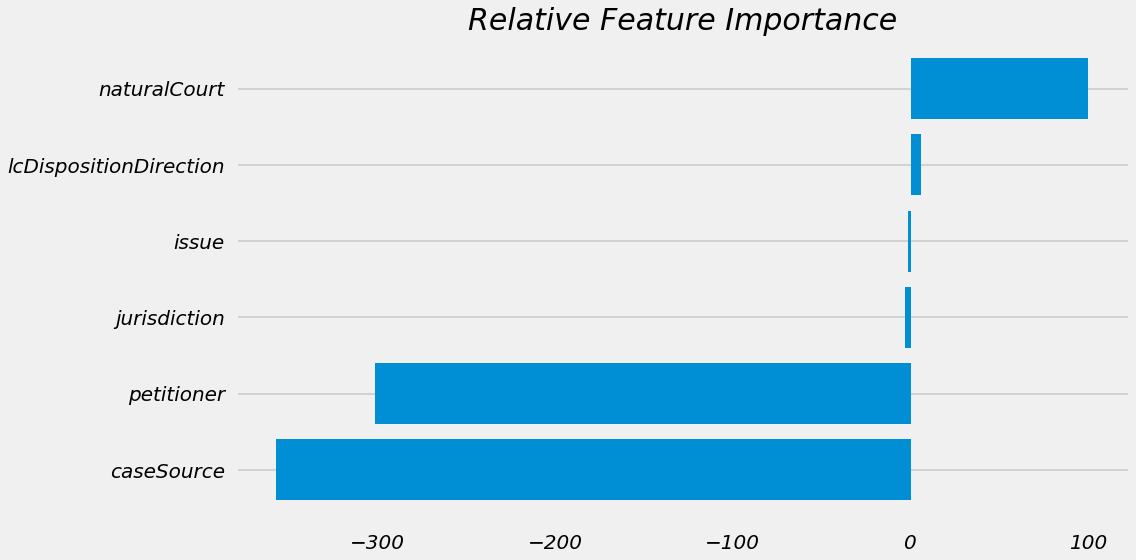

In [126]:
feature_importance = lgr.coef_[0]
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.style.use(['fivethirtyeight']) #making my graphs purdy
plt.style.use(['seaborn-poster'])
featfig = plt.figure(figsize = (16,8))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_title("Relative Feature Importance", size = 30, style = 'oblique')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=20, style = 'italic')
plt.xticks(style = 'italic', size = 20)
plt.grid(axis = 'x')
featfig.tight_layout()
plt.savefig('most important features.png')

# RFC

A Random Forest Classifier is a good for categorization models and will naturally address the mild class imbalance.

In [64]:
#instantiating the model
rfc = RandomForestClassifier(n_estimators=100, random_state=0, class_weight= 'balanced')

In [65]:
#fitting the model
rfc.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=0)

In [94]:
# making predictions
rfc_preds = rfc.predict(X_test)
rfc_preds_t = rfc.predict(X_train)

### Evaulating the Test Predictions

In [73]:
rfc_test_accuracy = accuracy_score(rfc_preds, y_test)
rfc_test_f1 = f1_score(rfc_preds, y_test)

In [76]:
print('Untuned Random Forest Classifier')
print("Testing Accuracy: {:.4}".format(rfc_test_accuracy))
print()
print("F1 Score: {:.4}".format(rfc_test_f1))

Untuned Random Forest Classifier
Testing Accuracy: 0.6082

F1 Score: 0.7011


In [77]:
confusion = confusion_matrix(y_test, rfc_preds)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print( f'True Positives: {TP}\n'
       f'True Negatives: {TN}\n', 
      f'False Positives: {FP}\n',
      f'False Negatives: {FN}\n')

True Positives: 312
True Negatives: 101
 False Positives: 148
 False Negatives: 118



### Evaualting the Training Predictions

In [80]:
rfc_train_accuracy = accuracy_score(rfc_preds_t, y_train)
rfc_test_f1 = f1_score(rfc_preds_t, y_train)

In [81]:
print('Untuned Random Forest Classifier')
print("Training Accuracy: {:.4}".format(rfc_train_accuracy))
print()
print("F1 Score: {:.4}".format(rfc_train_f1))

Untuned Random Forest Classifier
Training Accuracy: 0.9849

F1 Score: 0.7011


In [83]:
confusion = confusion_matrix(y_train, rfc_preds_t)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print( f'True Positives: {TP}\n'
       f'True Negatives: {TN}\n', 
      f'False Positives: {FP}\n',
      f'False Negatives: {FN}\n')

True Positives: 1560
True Negatives: 1112
 False Positives: 15
 False Negatives: 26



## Analysis

While more accutate then the logistic regression, this model is extremely overfit to the training data. Lets do a cross validated gridsearch to see if we can reduce the variance.

## Tuning hyper parameters

In [84]:
from sklearn.model_selection import GridSearchCV#importing the gridsearch module

In [85]:
param_grid = { 
    'n_estimators': [100, 150, 200, 250],
    'criterion': ['gini'],
    'max_depth': range(9,15),
    'max_features': ['auto']
}#the hyper parameters I will test

In [86]:
#instanting the search
grid_tree = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)

In [87]:
#fitting
grid_tree.fit(X_train, y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.4min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': range(9, 15),
                         'max_features': ['auto'],
                         'n_estimators': [100, 150, 200, 250]},
             scoring='accuracy', verbose=1)

In [93]:
#making predictions
grfc_preds = grid_tree.predict(X_test)
grfc_preds_t = grid_tree.predict(X_train)

### Evaulating the Testing Prediction

In [90]:
grfc_test_accuracy = accuracy_score(grfc_preds, y_test)
grfc_test_f1 = f1_score(grfc_preds, y_test)

In [91]:
print('Untuned Random Forest Classifier')
print("Testing Accuracy: {:.4}".format(grfc_test_accuracy))
print()
print("F1 Score: {:.4}".format(grfc_test_f1))

Untuned Random Forest Classifier
Testing Accuracy: 0.6318

F1 Score: 0.7329


In [99]:
confusion = confusion_matrix(y_test, grfc_preds)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print( f'True Positives: {TP}\n'
       f'True Negatives: {TN}\n', 
      f'False Positives: {FP}\n',
      f'False Negatives: {FN}\n')

True Positives: 343
True Negatives: 86
 False Positives: 163
 False Negatives: 87



### Evaulating the Training Predictions

In [95]:
grfc_train_accuracy = accuracy_score(grfc_preds_t, y_train)
grfc_train_f1 = f1_score(grfc_preds_t, y_train)

In [97]:
print('Untuned Random Forest Classifier')
print("Testing Accuracy: {:.4}".format(grfc_train_accuracy))
print()
print("F1 Score: {:.4}".format(grfc_test_f1))

Untuned Random Forest Classifier
Testing Accuracy: 0.8087

F1 Score: 0.7329


In [98]:
confusion = confusion_matrix(y_train, grfc_preds_t)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]
print( f'True Positives: {TP}\n'
       f'True Negatives: {TN}\n', 
      f'False Positives: {FP}\n',
      f'False Negatives: {FN}\n')

True Positives: 1510
True Negatives: 684
 False Positives: 443
 False Negatives: 76



## Analysis

This model is slightly more accurate and has a higher f1 score, but worringly, is also fairly overfit to the trainin data. Lets check the best hyper parameters and see if they are at the extremes of our ranges.

In [100]:
grid_tree.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'auto',
 'n_estimators': 200}

Max depth is at the bottom of our range, lets run it again with lower possibiliies 

## Further Tuning

In [110]:
param_grid = { 
    'n_estimators': [100, 150, 200, 250],
    'criterion': ['gini'],
    'max_depth': range(1,10),
    'max_features': ['auto']
}#the hyper parameters I will test

In [102]:
#instanting the search
grid_tree = GridSearchCV(RandomForestClassifier(), param_grid, cv=10, scoring='accuracy', verbose=1, n_jobs=-1)

In [103]:
grid_tree.fit(X_train, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   44.1s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  1.7min finished


GridSearchCV(cv=10, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': range(1, 10),
                         'max_features': ['auto'],
                         'n_estimators': [100, 150, 200, 250]},
             scoring='accuracy', verbose=1)

In [109]:
grid_tree.best_params_

{'criterion': 'gini',
 'max_depth': 9,
 'max_features': 'auto',
 'n_estimators': 200}

Looks like a max depth of nine was already a sweet spot, so this overfit model is the best we can do with only tuning our hyperparameters